In [5]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00


 Overview

The Audio Spectrogram Transformer model was proposed in AST: Audio Spectrogram Transformer by Yuan Gong, Yu-An Chung, James Glass. The Audio Spectrogram Transformer applies a Vision Transformer to audio, by turning audio into an image (spectrogram). The model obtains state-of-the-art results for audio classification.

The abstract from the paper is the following:

In the past decade, convolutional neural networks (CNNs) have been widely adopted as the main building block for end-to-end audio classification models, which aim to learn a direct mapping from audio spectrograms to corresponding labels. To better capture long-range global context, a recent trend is to add a self-attention mechanism on top of the CNN, forming a CNN-attention hybrid model. However, it is unclear whether the reliance on a CNN is necessary, and if neural networks purely based on attention are sufficient to obtain good performance in audio classification. In this paper, we answer the question by introducing the Audio Spectrogram Transformer (AST), the first convolution-free, purely attention-based model for audio classification. We evaluate AST on various audio classification benchmarks, where it achieves new state-of-the-art results of 0.485 mAP on AudioSet, 95.6% accuracy on ESC-50, and 98.1% accuracy on Speech Commands V2.

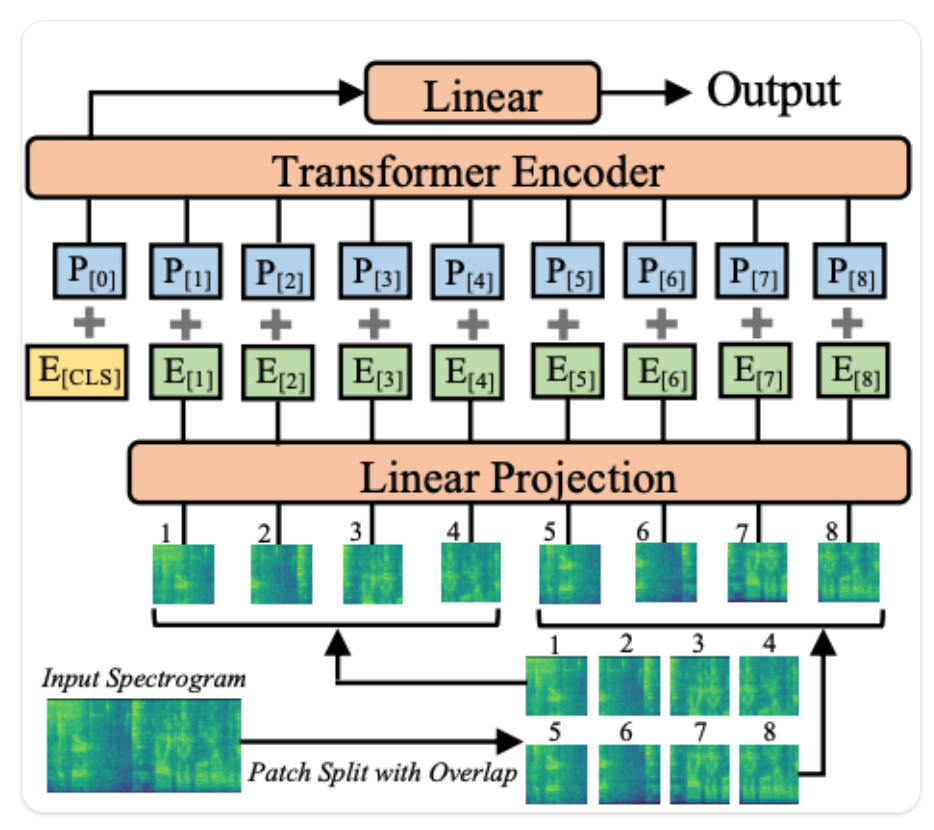

Audio Spectrogram Transformer architecture. Taken from the original paper.

This model was contributed by nielsr. The original code can be found here.
Usage tips

When fine-tuning the Audio Spectrogram Transformer (AST) on your own dataset, it’s recommended to take care of the input normalization (to make sure the input has mean of 0 and std of 0.5). ASTFeatureExtractor takes care of this. Note that it uses the AudioSet mean and std by default. You can check ast/src/get_norm_stats.py to see how the authors compute the stats for a downstream dataset.
Note that the AST needs a low learning rate (the authors use a 10 times smaller learning rate compared to their CNN model proposed in the PSLA paper) and converges quickly, so please search for a suitable learning rate and learning rate scheduler for your task.

In [1]:
from transformers import ASTConfig, ASTModel

# Initializing a AST MIT/ast-finetuned-audioset-10-10-0.4593 style configuration
configuration = ASTConfig()

# Initializing a model (with random weights) from the MIT/ast-finetuned-audioset-10-10-0.4593 style configuration
model = ASTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [2]:
configuration

ASTConfig {
  "attention_probs_dropout_prob": 0.0,
  "frequency_stride": 10,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_length": 1024,
  "model_type": "audio-spectrogram-transformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_mel_bins": 128,
  "patch_size": 16,
  "qkv_bias": true,
  "time_stride": 10,
  "transformers_version": "4.38.2"
}

In [3]:
model

ASTModel(
  (embeddings): ASTEmbeddings(
    (patch_embeddings): ASTPatchEmbeddings(
      (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ASTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ASTLayer(
        (attention): ASTAttention(
          (attention): ASTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ASTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ASTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

ASTFeatureExtractor

ASTModel

In [4]:
from transformers import AutoProcessor, ASTModel
import torch
from datasets import load_dataset

dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

processor = AutoProcessor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# audio file is decoded on the fly
inputs = processor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for hf-internal-testing/librispeech_asr_demo contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hf-internal-testing/librispeech_asr_demo
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset fro

Generating validation split: 0 examples [00:00, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

[1, 1214, 768]

In [5]:
model

ASTModel(
  (embeddings): ASTEmbeddings(
    (patch_embeddings): ASTPatchEmbeddings(
      (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ASTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ASTLayer(
        (attention): ASTAttention(
          (attention): ASTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ASTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ASTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

ASTForAudioClassification

In [6]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification
from datasets import load_dataset
import torch

dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# audio file is decoded on the fly
inputs = feature_extractor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_ids = torch.argmax(logits, dim=-1).item()
predicted_label = model.config.id2label[predicted_class_ids]
predicted_label

# compute loss - target_label is e.g. "down"
target_label = model.config.id2label[0]
inputs["labels"] = torch.tensor([model.config.label2id[target_label]])
loss = model(**inputs).loss
round(loss.item(), 2)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for hf-internal-testing/librispeech_asr_demo contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hf-internal-testing/librispeech_asr_demo
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


0.17

In [7]:
predicted_label

'Speech'